# Clustering aircraft trajectories with recursive DBSCAN

In [1]:
%matplotlib inline
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from traffic.data import nm_airspaces
from traffic.core.projection import CH1903, EuroPP
from traffic.drawing import countries
from traffic.data.samples import switzerland
from sectflow.plot import clusters_plot2d, plot_trajs
from trdbscan import TrajRDBSCAN

#### <br> Use the Swiss example from traffic library

In [3]:
sw = (
    switzerland.assign(
        log_altitude=lambda df: df.altitude.apply(lambda x: np.log10(x) if x > 0 else x)
    )
    .assign_id()
    .eval()
)

#### <br> Same parameters as the DBSCAN traffic example (nb_samples, min_pts) + specify a decrement ratio

In [4]:
features = ["x", "y", "track_unwrapped"]
tc = sw.clustering(
    nb_samples=15,
    features=features,
    projection=CH1903(),
    clustering=TrajRDBSCAN(
        features, min_pts=10, decrement_ratio=0.97, n_iteration_limit=10
    ),
    transform=StandardScaler(),
).fit_predict()

Top 10 anomalies:
[119, 126, 143, 343, 467, 627, 770, 782, 1006, 1059]


#### <br> Display the number of flights for each cluster, -1 being anomalies

In [5]:
print(dict(tc.groupby(["cluster"]).agg({"flight_id": "nunique"}).flight_id))

{-1: 653, 0: 121, 1: 19, 2: 110, 3: 15, 4: 17, 5: 23, 6: 15, 7: 12, 8: 60, 9: 14, 10: 66, 11: 48, 12: 12, 13: 29, 14: 30}


#### <br> Plot the traffic flows with sectflow plot functions

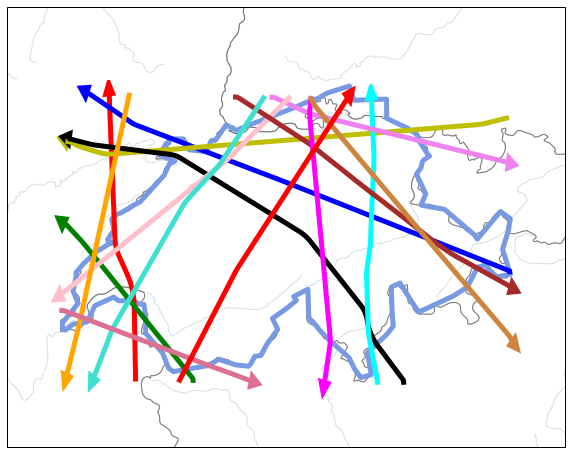

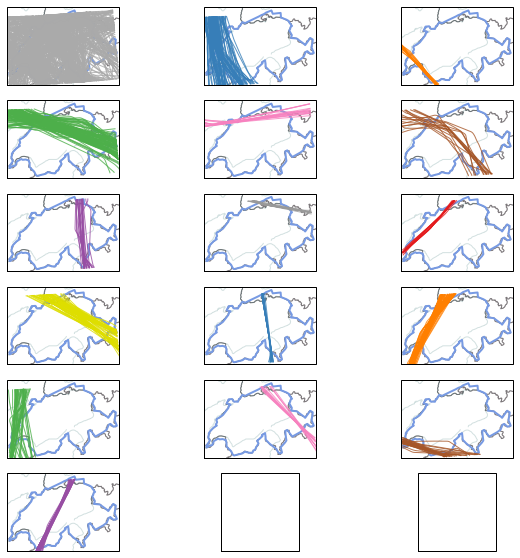

In [6]:
clusters_plot2d(nm_airspaces["LS"], tc, 50, EuroPP(), plot_trajs=False)
plt.savefig("swiss_rdbscan.png")
plot_trajs(tc, nm_airspaces["LS"])

#### <br> Plot main anomalies detected

In [7]:
ano_indices = [119, 126, 143, 343, 467, 627, 770, 782, 1006, 1059]
fl = list(f.flight_id for f in tc)
ano_ids = [fl[index] for index in ano_indices]
ano_tc = tc.query(f"flight_id in {ano_ids}")
ano_tc

,count
flight_id,
LZB408_713,167
TAP1273_823,167
AZA324_1025,151
RYR94FT_923,94
BAW2649_442,88
DLH55E_364,88
EWG9581_278,88
MNB351_880,69
HFY312P_821,65


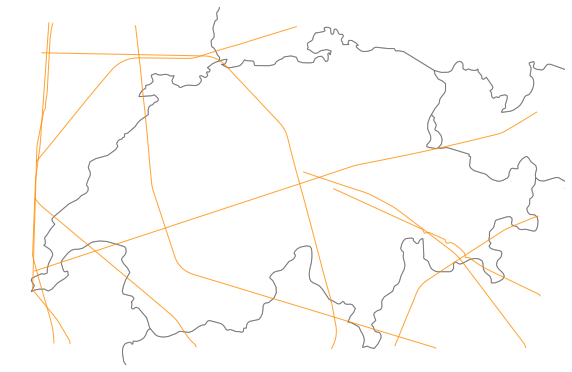

In [8]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EuroPP()))
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    ax.add_feature(countries())
    ano_tc.plot(ax, color="darkorange")